Clone YOLOv5 Repository

In [1]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17059, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 17059 (delta 18), reused 27 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17059/17059), 15.68 MiB | 16.69 MiB/s, done.
Resolving deltas: 100% (11708/11708), done.
/content/yolov5


Install Dependencies as necessary

In [2]:
!pip install -qr requirements.txt
import torch
from IPython.display import Image, clear_output
from utils.downloads import attempt_download

#clear output
print('Setup Complete. Using torch %s %s' %(torch.__version__,torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 kB 25.9 MB/s eta 0:00:00
Setup Complete. Using torch 2.5.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40, uuid=47118b93-5110-11cb-9f64-3371ca115821, L2_cache_size=4MB)


In [3]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00


In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="uwcEFW4wjiuJayCklGmS")
project = rf.workspace("isd-9m8gw").project("helmet-npjgp")
version = project.version(1)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Helmet-1 in yolov5pytorch:: 100%|██████████| 50/50 [00:00<00:00, 7193.85it/s]


In [5]:
%pwd

'/content/yolov5'

In [6]:
dataset.location

'/content/yolov5/Helmet-1'

In [7]:
%cd /content/yolov5

/content/yolov5


In [8]:
%cat {dataset.location}/data.yaml

names:
- Helmet
nc: 1
roboflow:
  license: CC BY 4.0
  project: helmet-npjgp
  url: https://universe.roboflow.com/isd-9m8gw/helmet-npjgp/dataset/1
  version: 1
  workspace: isd-9m8gw
test: ../test/images
train: Helmet-1/train/images
val: Helmet-1/valid/images


Define number of classes based on YAML

In [9]:
import yaml

with open(dataset.location + "/data.yaml",'r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])

In [10]:
num_classes

'1'

Model Configuration

In [11]:
%cat /content/yolov5/models/yolov5s.yaml

# Ultralytics YOLOv5 🚀, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4],

Customize iPython writefile so we can write number of class varibale to 1 from 80

In [12]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line,cell):
  with open(line,'w') as f:
    f.write(cell.format(**globals()))

In [13]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml
# Ultralytics YOLOv5 🚀, AGPL-3.0 license

# Parameters
nc: {num_classes} # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [-1, 3, C3, [256, False]], # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]], # cat head P4
    [-1, 3, C3, [512, False]], # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]], # cat head P5
    [-1, 3, C3, [1024, False]], # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
  ]


Train Custom YOLOv5s

We will pass following argument:
1. img: define input image size
2. batch: determine batch size
3. epochs: define the numnber of training epochs
4. data: set the path to your yaml file'
5. cfg: specify your model configuration
6. weights: specify a custom path to weights.
7. name: result names
8. nosave: only save the final checkpoint
9. cache: cache images for faster training

In [14]:
#train for 200 epochs
# time its performace

%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 50 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results  --cache

/content/yolov5
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-22 06:06:50.709902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 06:06:50.729242: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 06:06:50.735304: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452

Evaluate Custom YOLOv5 Detector Performance
You can view the training graphs associated with a training job in the /content/yolov5/runs/train/yolov5s_results/results.png folder.

Training losses and performance metrics are also saved to Tensorboard and also to a logfile defined above with the --name flag when we train. In our case, we named this yolov5s_results.

Note from Glenn: Partially completed results.txt files can be plotted with from utils.utils import plot_results; plot_results().

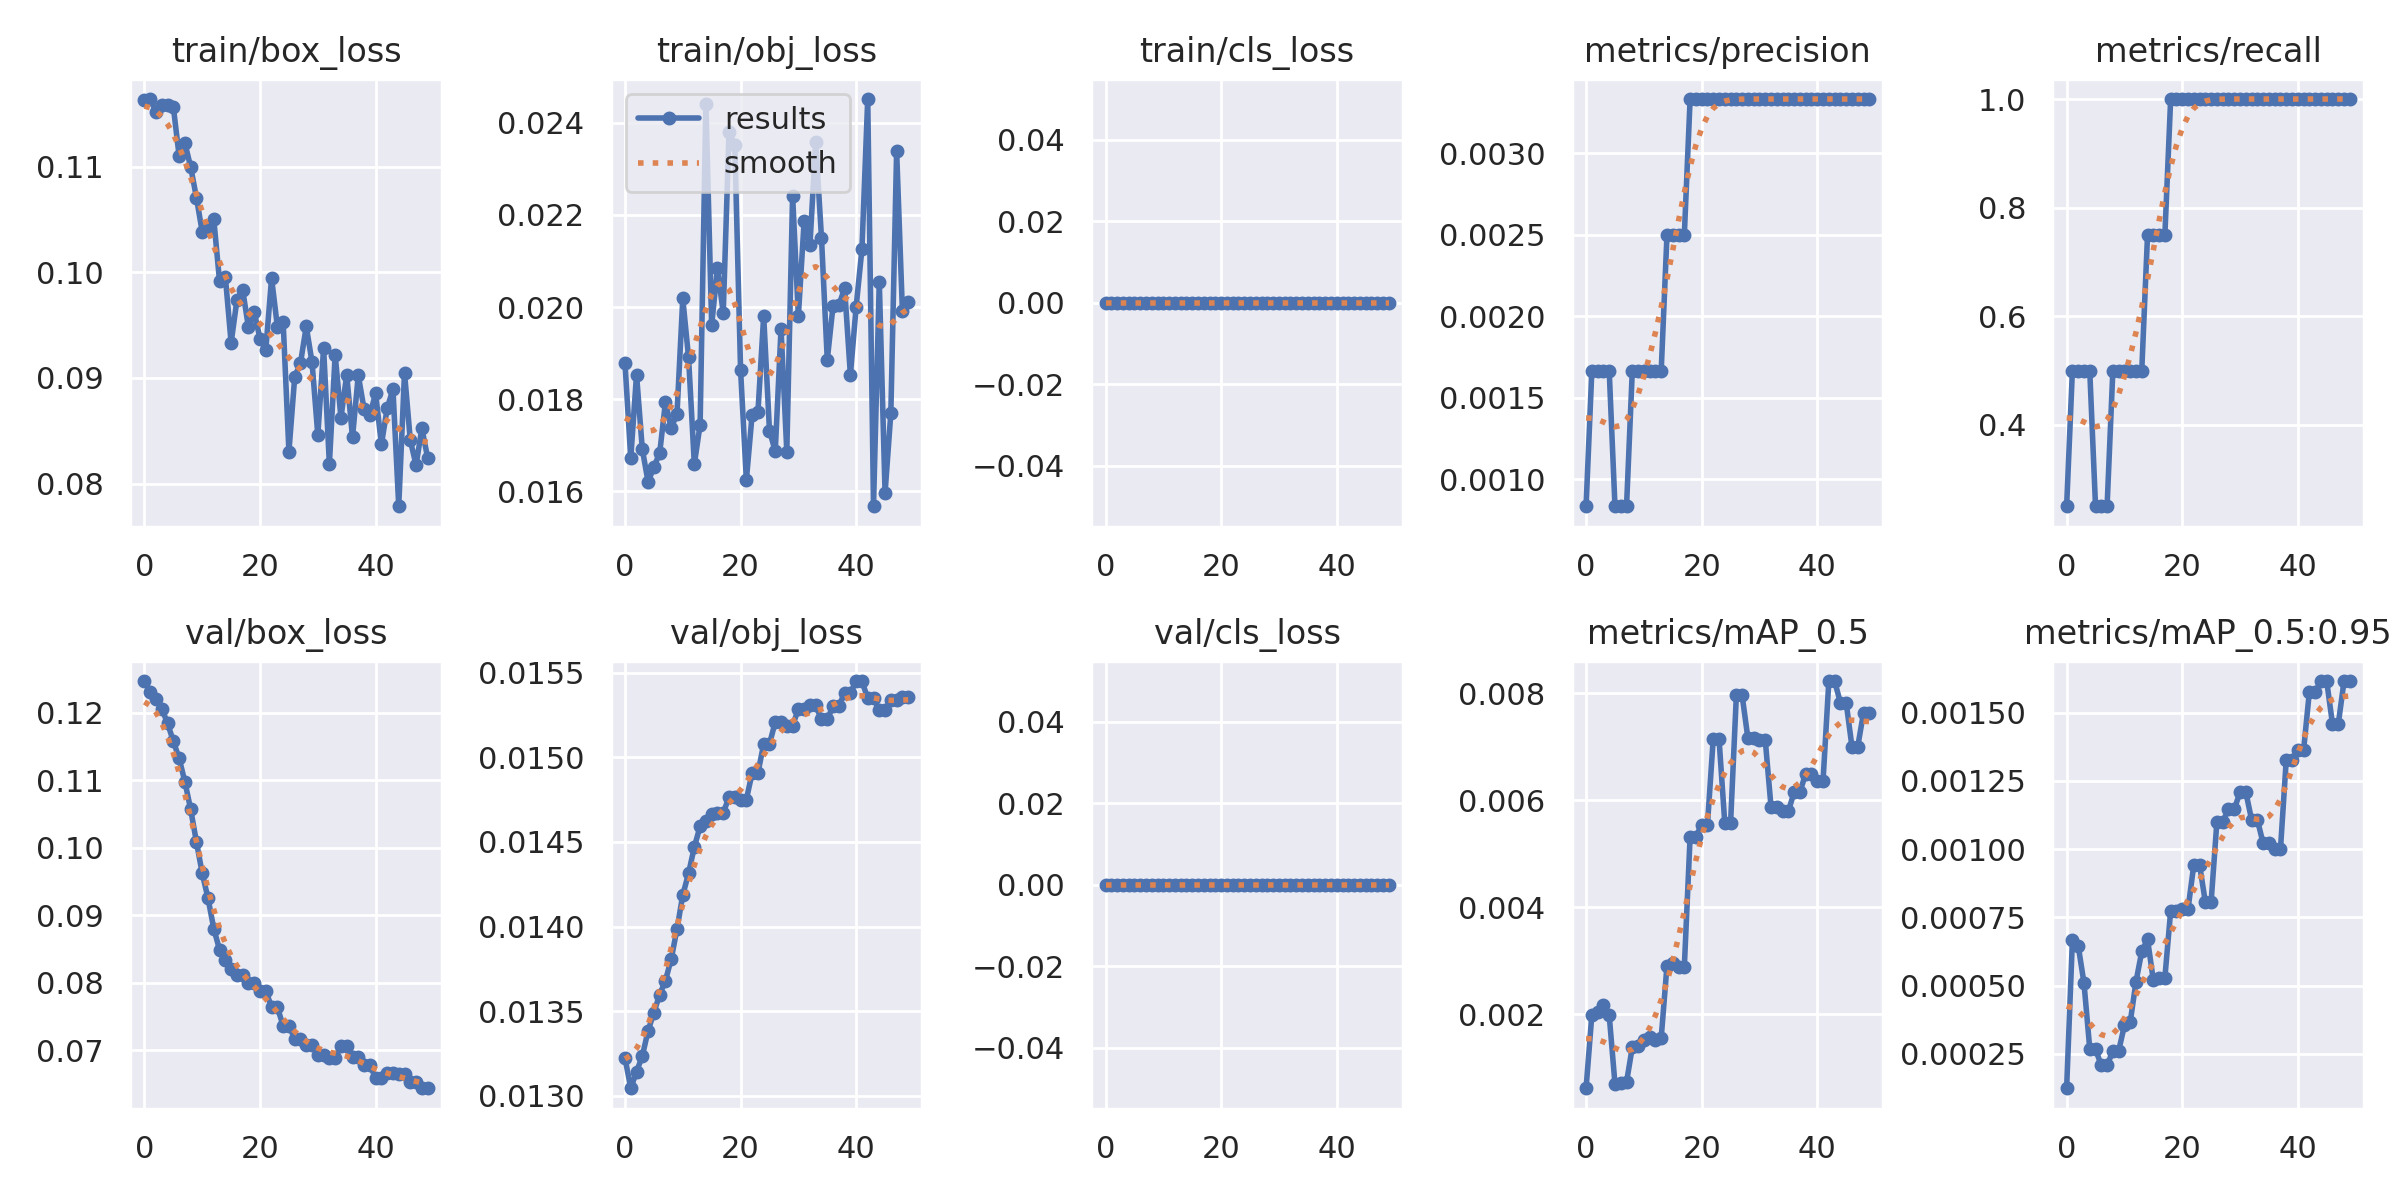

In [18]:
from utils.plots import plot_results
Image(filename = '/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)

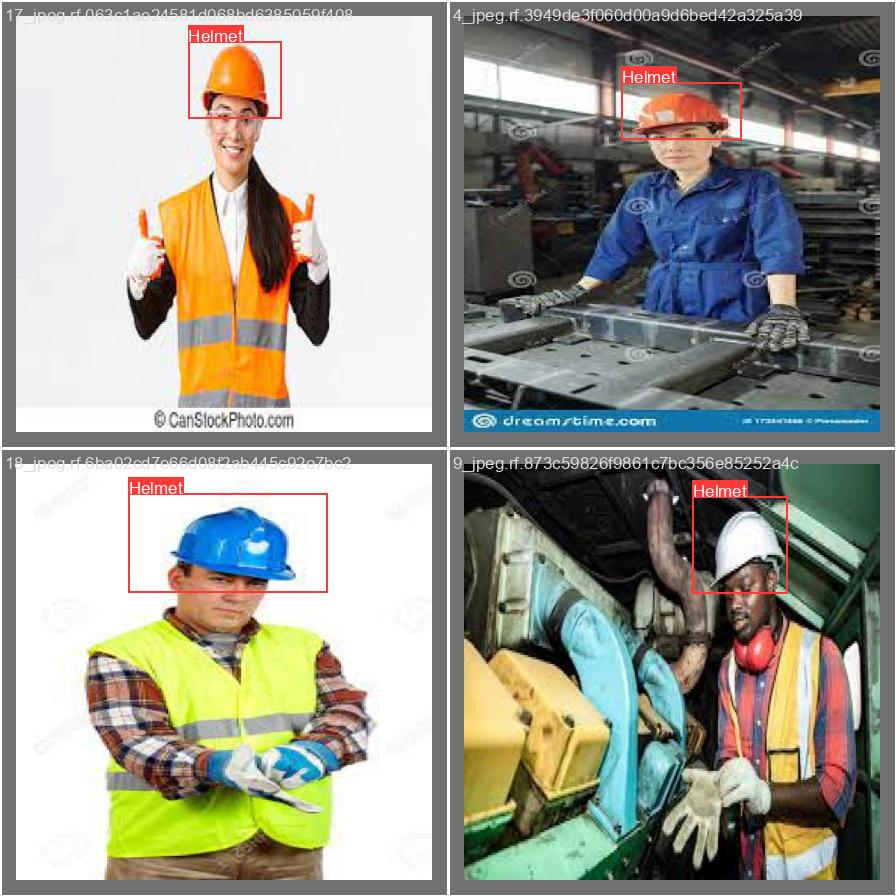

In [19]:
Image(filename = "/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg",width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


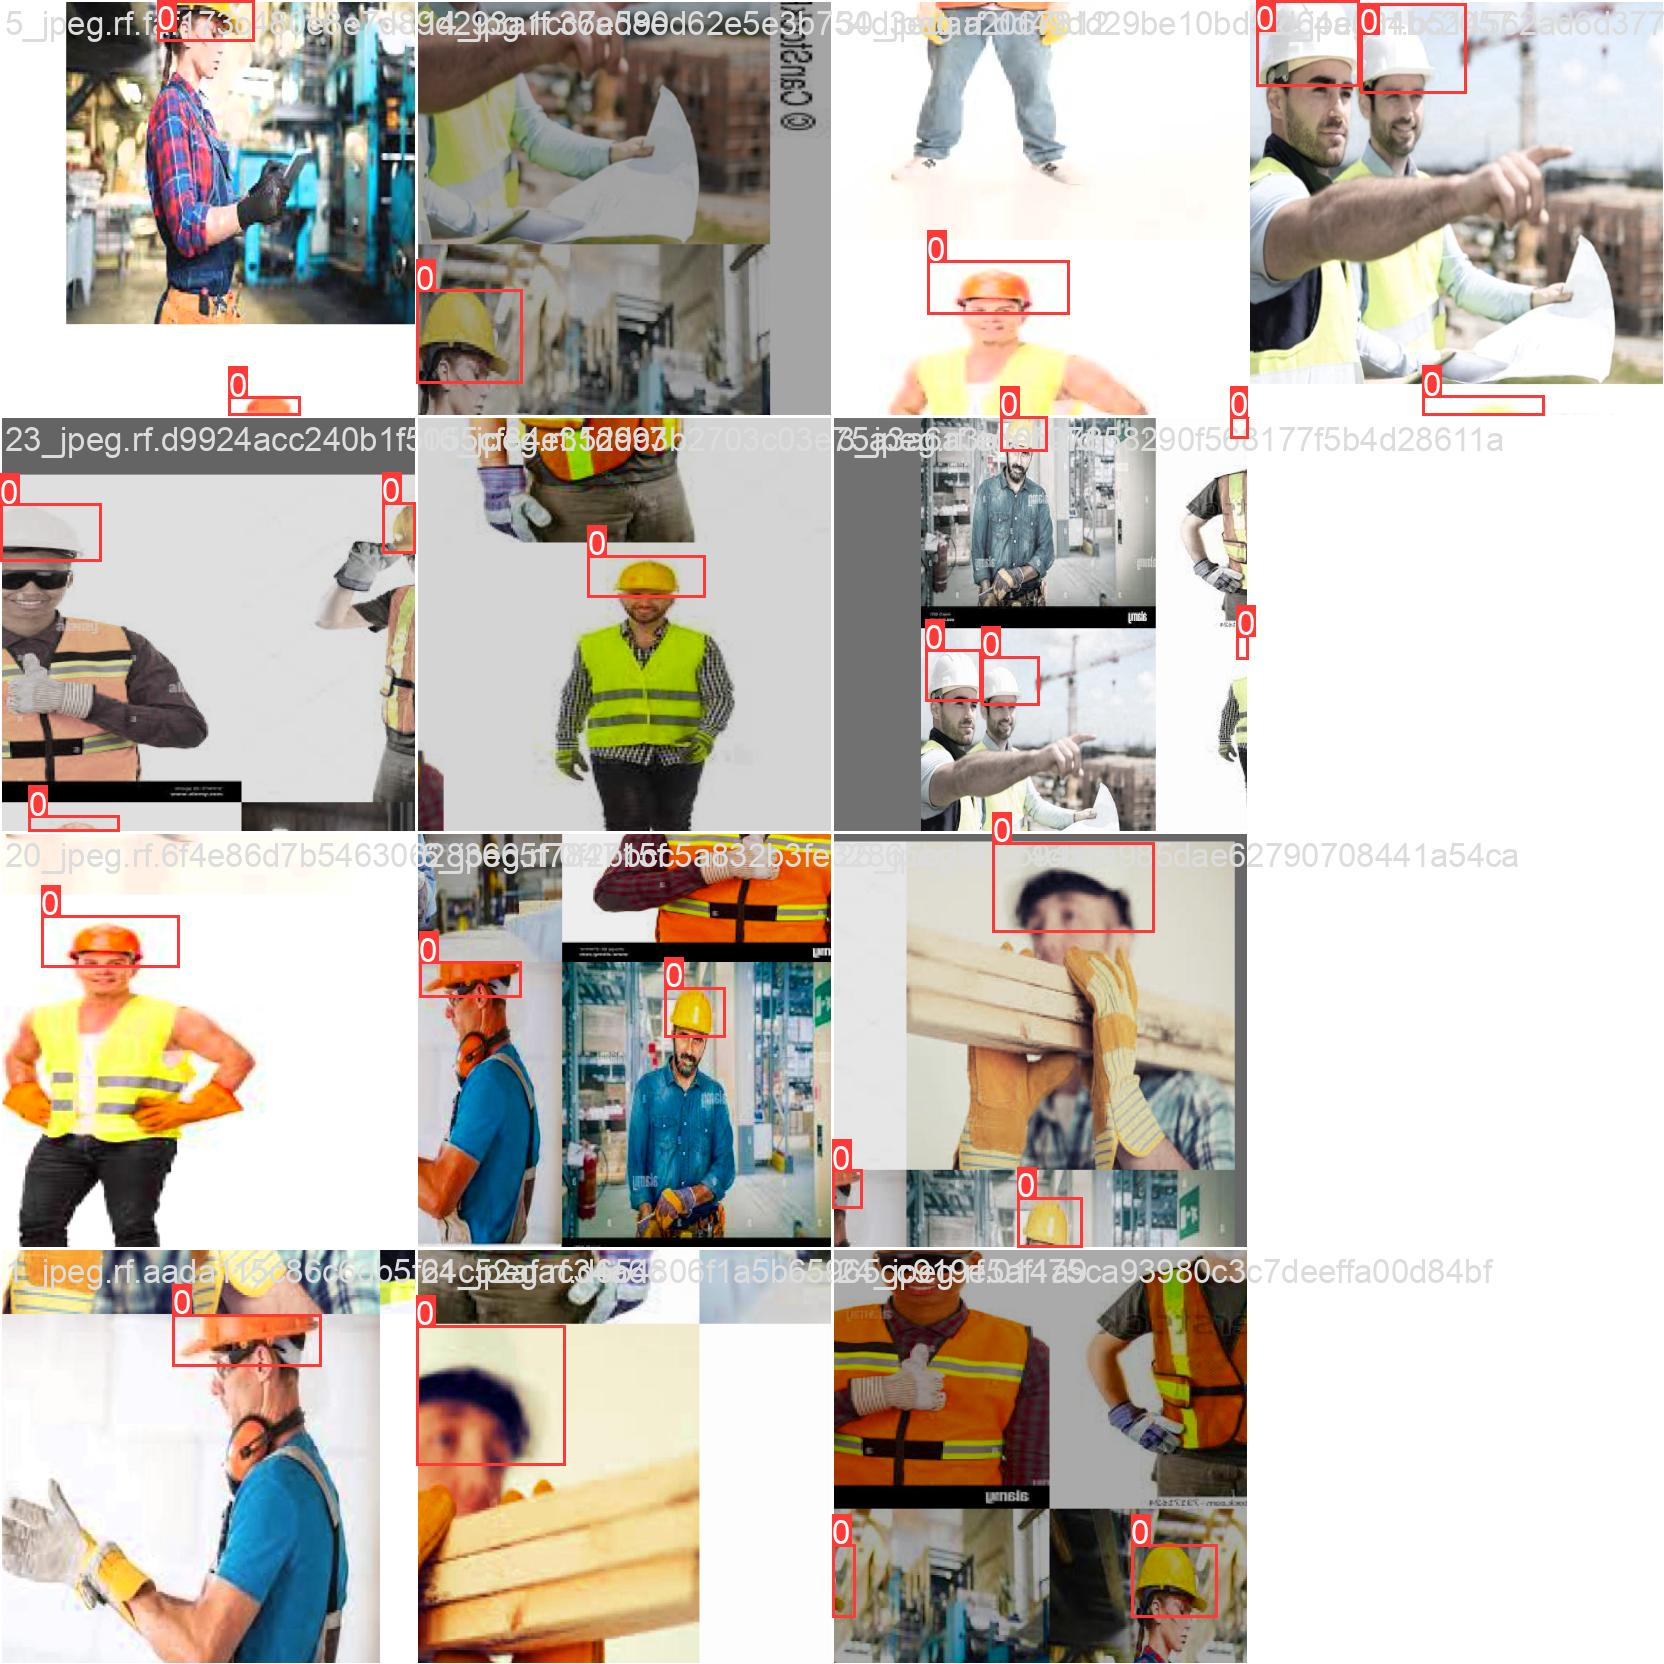

In [20]:

# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

Check model performance on our test set

In [21]:
%ls runs/

train/


In [22]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [24]:
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source /content/yolov5/Helmet-1/test/images


/content/yolov5
detect: weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'], source=/content/yolov5/Helmet-1/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-386-g81ac034a Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/2 /content/yolov5/Helmet-1/test/images/19_jpeg.rf.d750460b539057a1ed0980c441e5d371.jpg: 416x416 (no detections), 7.1ms
image 2/2 /content/yolov5/Helmet-1/test/images/8_jpeg.rf.0cc4820f5ad00f80e5e5cc625b94f0d6.jpg: 416x416 (no detections)

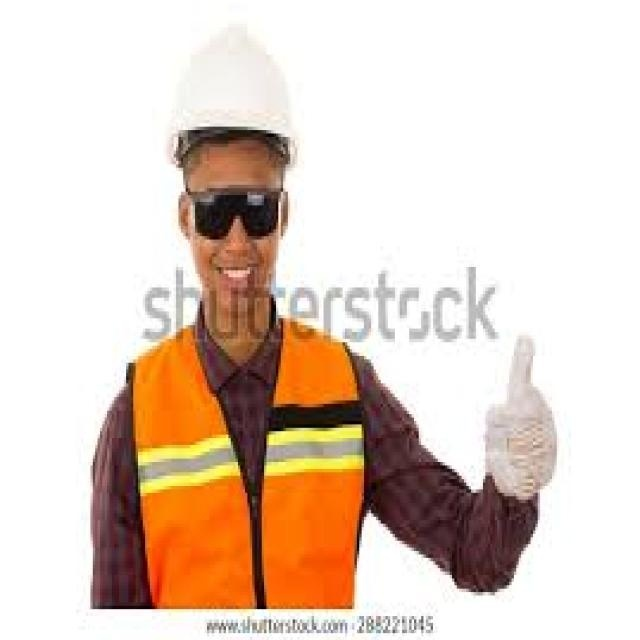

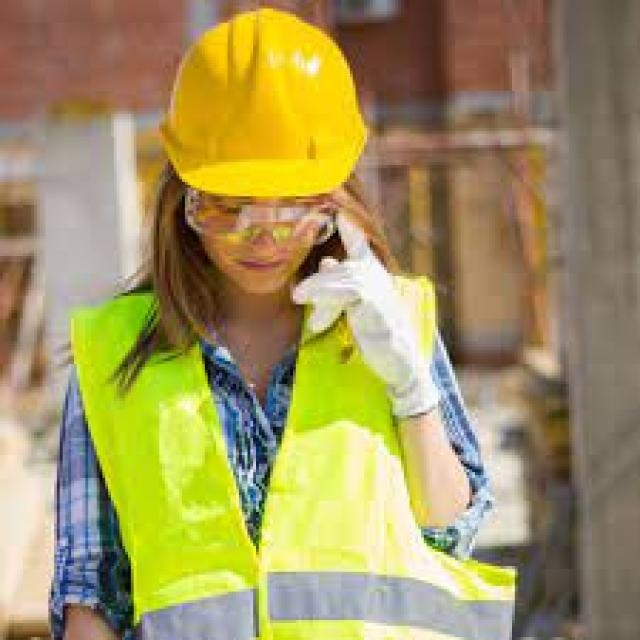

In [25]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))